In [1]:
import pandas as pd


C:\Users\voqua\AppData\Local\Temp\ipykernel_35632\2035458946.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
myDF = pd.read_csv("../dataset/placementDecisions_rl_los_cost_1.csv")

In [5]:
max(myDF['ocp_wr_total'])

168.0

In [6]:
myDF.columns

Index(['Unnamed: 0', 'ocp_jl', 'ocp_wr', 'ocp_hd', 'class_mild', 'need',
       'placement', 'ocp_jl_low_los', 'ocp_jl_total', 'ocp_wr_low_los',
       'ocp_wr_total', 'ocp_hd_low_los', 'ocp_hd_total'],
      dtype='object')

In [7]:
myDF.drop(["Unnamed: 0", "ocp_jl", "ocp_wr", "ocp_hd"], inplace= True, axis = 1)

In [8]:
# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in myDF.iterrows():
    if item['placement'] == 'work release':
        myDF['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        myDF['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        myDF['placement'].iat[ind] = '2'

#object to int
myDF['placement'] = pd.to_numeric(myDF['placement'])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [10]:
y = myDF["placement"]
X = myDF.drop(["placement"], axis = 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size = 0.7, random_state = 50)

## A random model acting as a baseline for performance comparison

In [24]:
rf1 = RandomForestClassifier(random_state= 50)
rf1.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [38]:
rf1.feature_importances_

array([0.06308522, 0.12608581, 0.05013295, 0.05449946, 0.05055541,
       0.55286772, 0.05036358, 0.05240985])

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [25]:
y_pred = rf1.predict(X_test)
print('f1_score' + str(f1_score(y_test, y_pred, average='weighted')))
print('precision_score: ' + str(precision_score(y_test, y_pred, average ='weighted')))
print('recall_score: ' + str(recall_score(y_test, y_pred, average ='weighted')))

f1_score0.7977764649264536
precision_score: 0.7980923002566425
recall_score: 0.797544475068905


In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf1.predict_proba(X_test), multi_class='ovr' )

0.9154295639264131

## Fine-tuning a model and Optimizing the performance

In [13]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [14]:
param_grid = {'n_estimators': [100,150,200, 230], 'max_depth': [None, 5, 10], 
              'min_samples_leaf': [2, 5, 10],
              'min_samples_split': [2, 4, 6], 'max_features': ["sqrt", "log2", None]}

In [19]:
sh = HalvingGridSearchCV(rf1, param_grid, cv = 5, factor = 2, random_state=50).fit(X_train, y_train)

In [20]:
sh.best_params_

{'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 230}

In [15]:
rf2a = RandomForestClassifier(max_depth= 5, max_features = 'log2', min_samples_leaf = 5,
 min_samples_split = 6, n_estimators = 230, random_state= 50)

In [29]:
rf2a.fit(X_train, y_train)
y_preda = rf2a.predict(X_test)
print('f1_score:' + str(f1_score(y_test, y_preda, average='weighted')))
print('precision_score: ' + str(precision_score(y_test, y_preda, average ='weighted')))
print('recall_score: ' + str(recall_score(y_test, y_preda, average ='weighted')))

f1_score:0.8102529284949589
precision_score: 0.8166206634962851
recall_score: 0.8145828113254824


In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf2a.predict_proba(X_test), multi_class='ovr' )

0.9296582812413027

## Applying Cross Validation to the model

Since because Cross Validation doesn't support multi-class behaviors, I have to seperate the dataset into 3 smaller subsets and apply Cross Validation to each of them. At the end, I take the average of all as the overall performance score.

In [35]:
# placement 1 is Work Release
placement_1 = y.copy() 

In [36]:
# change a 3-class output to binary format, with Work Release program standing for 1 and not Work Release program for 2
placement_1[ placement_1 != 1] = 0

In [37]:
from sklearn.model_selection import cross_validate
cv_results_1 = cross_validate(rf2a, X, placement_1, cv = 3, scoring = 'roc_auc')
cv_results_1

{'fit_time': array([1.35043979, 1.32796717, 1.33312774]),
 'score_time': array([0.04317379, 0.04160261, 0.04186893]),
 'test_score': array([0.86646339, 0.89472275, 0.89919231])}

In [41]:
rf2a_0 = RandomForestClassifier(max_depth= 5, max_features = 'log2', min_samples_leaf = 5,
 min_samples_split = 6, n_estimators = 230, random_state= 50)

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf2a.predict_proba(X_test), multi_class='ovr' )

0.9296582812413027

Before I apply CV to placement_0, I got the performance of 1. roc_auc score. 

The reason is could be because when we change from 3-class ouptut to binary output, there will be a data imbalance since 2 classes represent "0" while only one class changes to "1".

=> Apply data resampling to see if rebalancing data causes significant change in performance score (roc_auc)

In [43]:
#placement 0 is Home Detention
myDF_minor = myDF[ myDF['placement'] == 0]
myDF_major = myDF[ myDF['placement'] != 0]

In [44]:
from sklearn.utils import resample, shuffle
downsized_myDF = resample(myDF_major, n_samples = len(myDF_minor), replace = False, random_state=42)
resampled_df = pd.concat([downsized_myDF, myDF_minor])

In [45]:
resampled_y = resampled_df['placement']
resampled_X = resampled_df.drop(['placement'], axis = 1)

In [46]:
placement_0 = resampled_y.copy()
placement_0[placement_0 == 0] = 3
placement_0[(placement_0 == 1) | (placement_0 == 2)] = 0
placement_0[placement_0 == 3] = 1

In [47]:
from sklearn.model_selection import cross_validate
cv_results_0 = cross_validate(rf2a_0, resampled_X, placement_0, cv = 3, scoring = 'roc_auc')
cv_results_0 
#something must be wrong over here.

{'fit_time': array([0.6799531 , 0.68368959, 0.60129213]),
 'score_time': array([0.02492189, 0.02661729, 0.021945  ]),
 'test_score': array([1., 1., 1.])}

After using data resampling, the performance scores are still 1.

=> The issue doesn't lie on data imbalance

In [48]:
# placement 2 is Jail 
rf2a_2 = RandomForestClassifier(max_depth= 5, max_features = 'log2', min_samples_leaf = 5,
 min_samples_split = 6, n_estimators = 230, random_state= 50)
placement_2 = y.copy()
placement_2[placement_2 == 1] = 0
placement_2[placement_2 == 2] = 1

In [49]:
from sklearn.model_selection import cross_validate
cv_results_2 = cross_validate(rf2a_2, X, placement_2, cv = 3, scoring = 'roc_auc')
cv_results_2 

{'fit_time': array([1.33444571, 1.32125807, 1.3554492 ]),
 'score_time': array([0.03988552, 0.03875017, 0.03611398]),
 'test_score': array([0.86161881, 0.88637812, 0.90167868])}

## SHAP LIBRARY - DATA INTERPRETATION

In [32]:
import shap

c:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
X_train.shape

(9311, 8)

In [53]:
explainer1 = shap.TreeExplainer(rf2a)
shap_values1 = explainer1(X_train)

In [54]:
pd1_wr = pd.DataFrame(shap_values1[:,:,0].values, columns=rf2a.feature_names_in_)
pd1_hd = pd.DataFrame(shap_values1[:,:,1].values, columns=rf2a.feature_names_in_)
pd1_jl = pd.DataFrame(shap_values1[:,:,2].values, columns=rf2a.feature_names_in_)

In [55]:
pd1_wr.to_csv("pd1_wr_tuned.csv", index = False)
pd1_hd.to_csv("pd1_hd_tuned.csv", index = False)
pd1_jl.to_csv("pd1_jl_tuned.csv", index = False)

In [56]:
shap.initjs()

In [37]:
shap_value_wr = shap_values1[:,:,0]

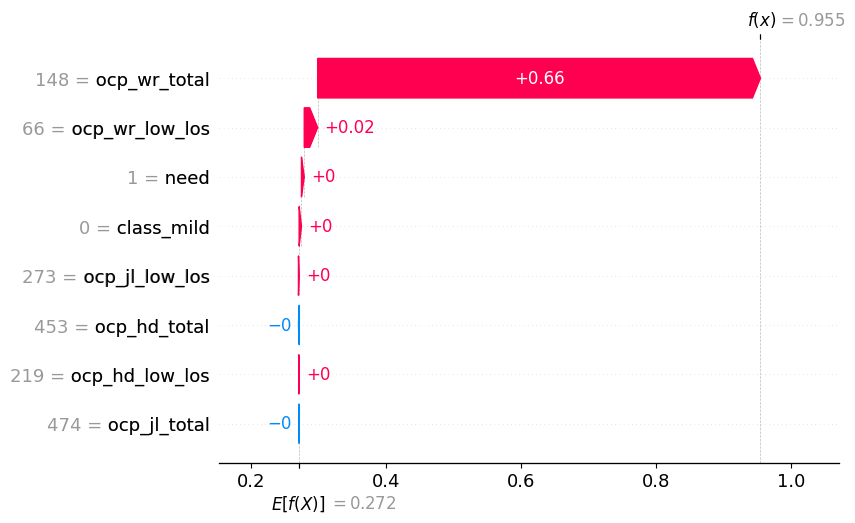

In [41]:
shap.plots.waterfall(shap_value_wr[10]) #waterfall plot

In [40]:
rf1.classes_ #work release, home detention, jail

array([0, 1, 2], dtype=int64)

Home detention

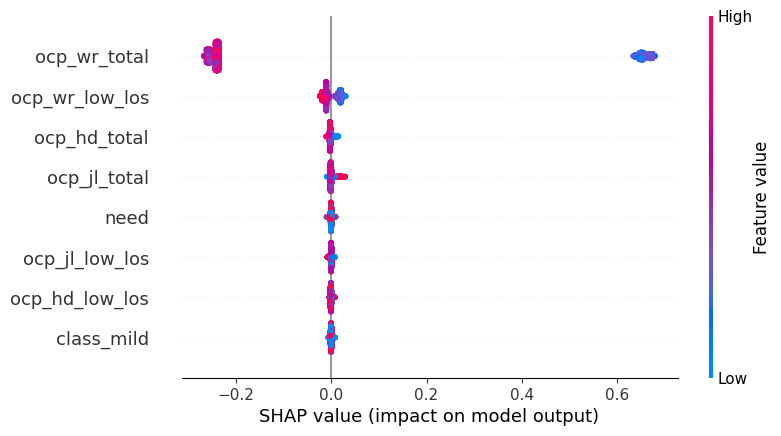

In [27]:
#tuned
shap.plots.beeswarm(shap_values1[:,:,0])

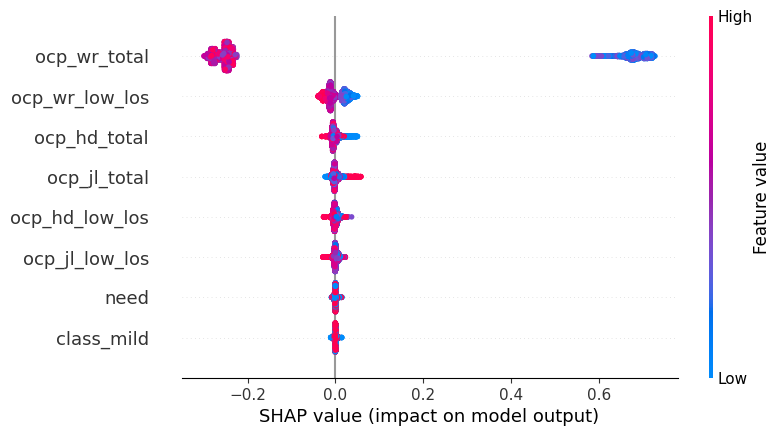

In [43]:
#pre_tuned
shap.plots.beeswarm(shap_values1[:,:,0])

In [47]:
# beeswarm without the dominant feature (ocp_wr_total)
shap.plots.beeswarm(shap_values1[:,[0,1,2,3,4,6,7],0])

NameError: name 'shap_values1' is not defined

Work Release

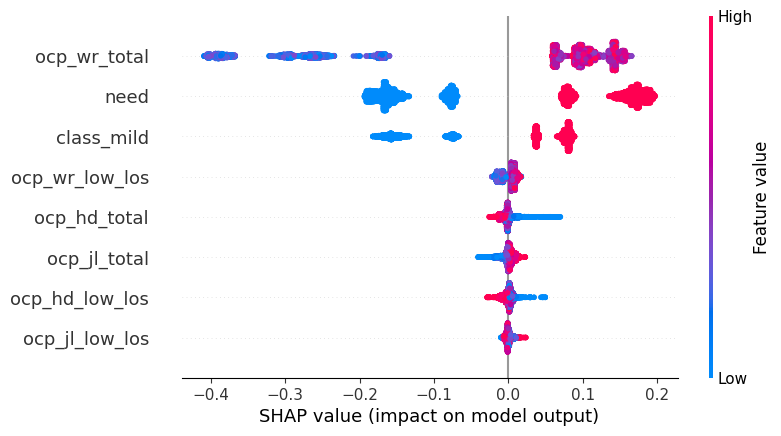

In [28]:
#tuned
shap.plots.beeswarm(shap_values1[:,:,1])

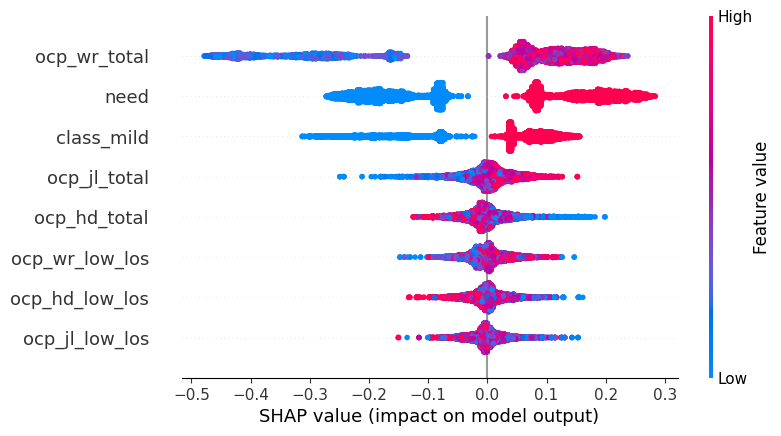

In [22]:
#pre-tuned
shap.plots.beeswarm(shap_values1[:,:,1])

Jail

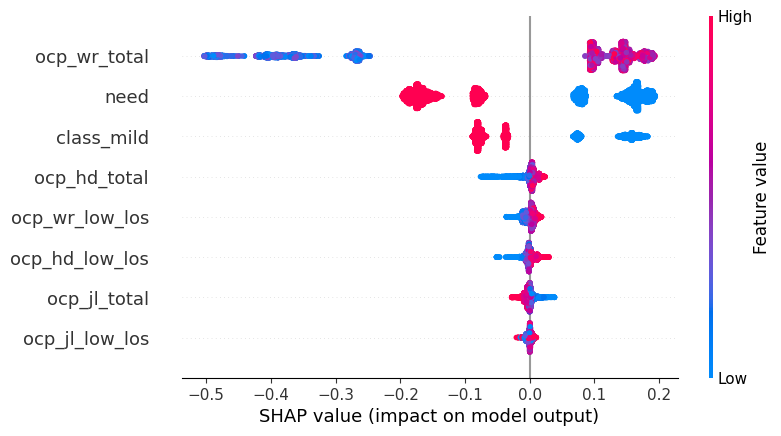

In [29]:
#tuned
shap.plots.beeswarm(shap_values1[:,:,2])

All 3 placements

In [31]:
shap_as_list=[]
for i in range(len(rf1.classes_)):
    shap_as_list.append(shap_values1.values[:,:,i])

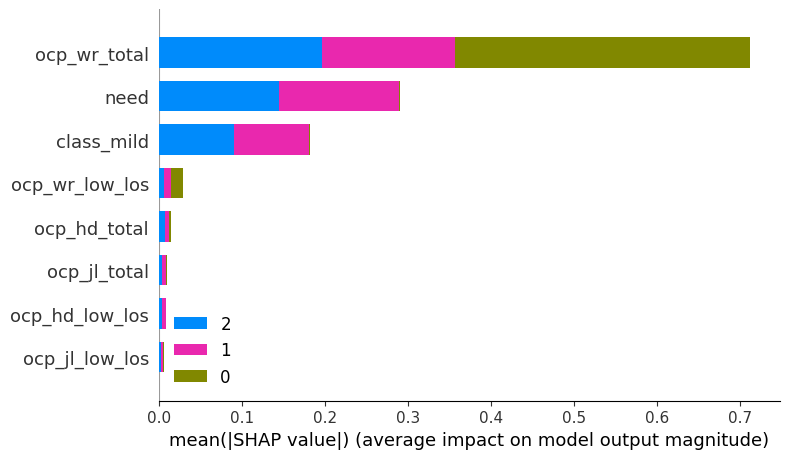

In [34]:
#tuned
shap.summary_plot(shap_as_list, X_train, plot_type="bar", class_names=rf1.classes_)

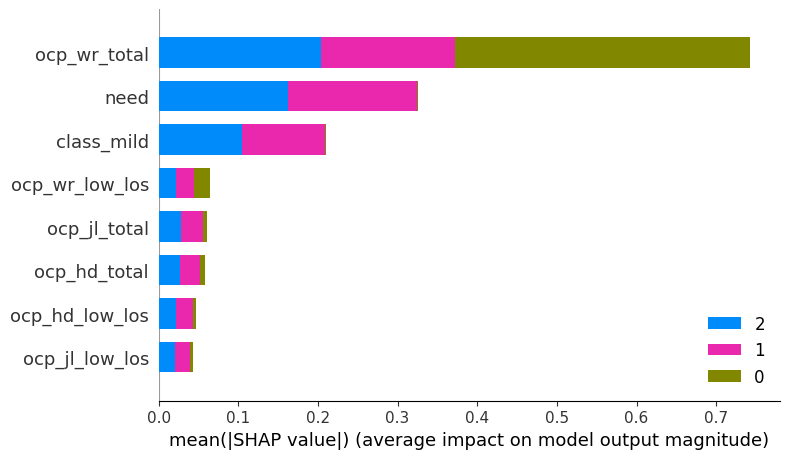

In [21]:
#pre-tuned
shap.summary_plot(shap_as_list, X_train, plot_type="bar", class_names=rf1.classes_)

## Data Progression

<Axes: >

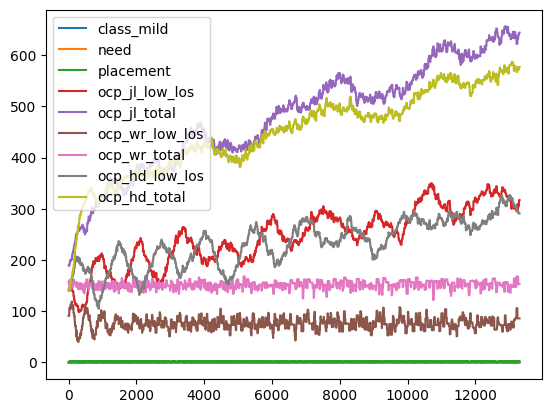

In [11]:
myDF.plot()